In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme = 'monokai', context = 'notebook',ticks=True, grid=False)
import warnings
warnings.filterwarnings('ignore')
#models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
#feature engineering
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from category_encoders import BinaryEncoder
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss
#evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, classification_report, plot_precision_recall_curve, plot_roc_curve
#saving models
import pickle

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


# Metrics Selection
    
    TP : If the model predict stroke, and actual is stroke : early treatment to prevent stroke
    TN : If the model predict false stroke, and actual is false stroke : safe
    FP : If the model predict stroke, but actual is false stroke : panic
    FN : If the model predict false stroke, but actual is stroke : stroke because not getting 
    an early treatment
    
Here I want to focus more on preveting FN, which means I will be using Recall

In [3]:
round(df.isna().sum()/len(df.index)*100, 2)

id                   0.00
gender               0.00
age                  0.00
hypertension         0.00
heart_disease        0.00
ever_married         0.00
work_type            0.00
Residence_type       0.00
avg_glucose_level    0.00
bmi                  3.93
smoking_status       0.00
stroke               0.00
dtype: float64

In [4]:
df.drop(df.loc[df['gender']=='Other'].index, inplace=True)

In [5]:
x = df.drop(['stroke','id'], axis = 1)
y = df['stroke']

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 2021)

# Model Selection

    DecisionTree
    Logistric Regression
    KNN

    I will be making 2 different transformer base on the way I fill the missing values in BMI 
    which will be mean and median

# Data Preprocessing

In [7]:
one_hot = OneHotEncoder(drop = 'first')
binary = BinaryEncoder()
imputer_mean = SimpleImputer(strategy = 'mean')
imputer_medi = SimpleImputer(strategy = 'median')

#MEAN IMPUTER
transformer_mean = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Simple Imputer', imputer_mean, ['bmi'])
], remainder = 'passthrough')

#MEDIAN IMPUTER
transformer_medi = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Simple Imputer', imputer_medi, ['bmi'])
], remainder = 'passthrough')

# SETUP MODELS(DEFAULT)

In [8]:
logreg = LogisticRegression(solver = 'liblinear')
tree = DecisionTreeClassifier(random_state = 2021)
knn = KNeighborsClassifier()

# CROSSVALIDATE MEAN AND MEDIAN TO SEE WHICH IS BETTER

In [9]:
def model_evaluation_cv_mean_or_median():
    model_test = [logreg, tree, knn]
    imputing_method_name = ['mean Imputing', 'median Imputing']
    imputing_method = [transformer_mean, transformer_medi]
    data_comparison = pd.DataFrame({'Model' : ['logreg', 'tree', 'knn']})
    skfold = StratifiedKFold(n_splits = 5)
    for i in range(len(imputing_method)):
        temp_list = []
        for j in range(len(model_test)):
            estimator = Pipeline([
            ('preprocess', imputing_method[i]),
            ('model', model_test[j])
        ])
            model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
            temp_list.append(round(model_cv.mean(),2))
        data_comparison[imputing_method_name[i]] = temp_list
    return data_comparison

model_evaluation_cv_mean_or_median()            

,Model,mean Imputing,median Imputing
0,logreg,0.00,0.00
1,tree,0.19,0.18
2,knn,0.02,0.01


# Conclusion for which imputer suits best? Median or Mean

    Impute the missing values by Mean is better than Median. Eventhough the data is pretty skewed which mean
    I should be using median instead, but as a performance, using Mean is much better than Median, and so
    I will be using Mean.

In [10]:
target = [df['stroke'], y_train, y_test]
for i in target:
    print('-'*30)
    print('Raw Data Stroke\n\n',i.value_counts())

------------------------------
Raw Data Stroke

 0    4860
1     249
Name: stroke, dtype: int64
------------------------------
Raw Data Stroke

 0    3402
1     174
Name: stroke, dtype: int64
------------------------------
Raw Data Stroke

 0    1458
1      75
Name: stroke, dtype: int64


# Resampling
    
    The difference(in quantity) between target 1 and 0 is quite huge. 
    And that might be the reason why the model performance is really low
    Which is why resampling is needed

# List of resampling method

In [11]:
randomover = RandomOverSampler(random_state = 2021)
randomunder = RandomUnderSampler(random_state = 2021)
smote = SMOTE(random_state = 2021)
nearmiss = NearMiss()

# QUICK FUNCTION FOR CROSSVALIDATE OVERALL MODELS

In [12]:
def model_evaluation_cv_mean_overall():
    model_test = [logreg, tree, knn]
    imbalance_method = [randomunder, randomover, smote, nearmiss]
    imbalance_method_name = ['randomunder', 'randomover', 'smote', 'nearmiss']
    data_comparison = pd.DataFrame({'Model' : ['logreg', 'tree', 'knn']})
    skfold = StratifiedKFold(n_splits = 5)
    for i in range(len(imbalance_method)):
        temp_list = []
        for j in range(len(model_test)):
            estimator = Pipeline([
            ('preprocess', transformer_mean),
            ('balancing', imbalance_method[i]),
            ('model', model_test[j])
        ])
            model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
            temp_list.append(round(model_cv.mean(),2))
        data_comparison[imbalance_method_name[i]] = temp_list
    return data_comparison

model_evaluation_cv_mean_overall()            

,Model,randomunder,randomover,smote,nearmiss
0,logreg,0.77,0.78,0.79,0.59
1,tree,0.68,0.11,0.16,0.75
2,knn,0.82,0.35,0.51,0.60


# QUICK FUNCTION FOR PREDICT TEST OVERALL MODELS

In [13]:
def overall_func():
    model_test = [logreg, tree, knn]
    imbalance_method = [randomunder, randomover, smote, nearmiss]
    imbalance_method_name = ['randomunder', 'randomover', 'smote', 'nearmiss']
    data_comparison = pd.DataFrame({'Model' : ['logreg', 'tree', 'knn']})
    for i in range(len(imbalance_method)):
        temp_list = []
        for j in range(len(model_test)):
            estimator = Pipeline([
                ('transformer', transformer_mean),
                ('balancing', imbalance_method[i]),
                ('model', model_test[j])])
            estimator.fit(x_train, y_train)
            y_pred = estimator.predict(x_test)
            temp_list.append(round(recall_score(y_test, y_pred),2))
        data_comparison[imbalance_method_name[i]] = temp_list
    return data_comparison
overall_func()

,Model,randomunder,randomover,smote,nearmiss
0,logreg,0.85,0.88,0.83,0.63
1,tree,0.73,0.17,0.12,0.68
2,knn,0.85,0.37,0.59,0.63


# MODEL PERFORMANCE CROSSVALIDATE -> PREDICT TEST

    
    RANDOM UNDER :
        logreg : 0.77 -> 0.85 difference +(0.08)
        tree : 0.68 -> 0.73 difference +(0.06)
        knn : 0.82 -> 0.85 difference +(0.03)
    RANDOM OVER :
        logreg : 0.78 -> 0.88 difference +(0.1)
        tree : 0.11 -> 0.17 difference +(0.06)
        knn : 0.35 -> 0.37 difference +(0.02)
    SMOTE :
        logreg : 0.77 -> 0.83 difference +(0.05)
        tree : 0.16 -> 0.12 difference -(0.04)
        knn : 0.51 -> 0.59 difference +(0.08)
    NEARMISS :
        logreg : 0.59 -> 0.63 difference +(0.04)
        tree : 0.75 -> 0.68 difference -(0.07)
        knn : 0.60 -> 0.63 difference +(0.03)
        
# Overall Best among the rest goes to Random Over Logreg with score of 0.88

<AxesSubplot:xlabel='bmi'>

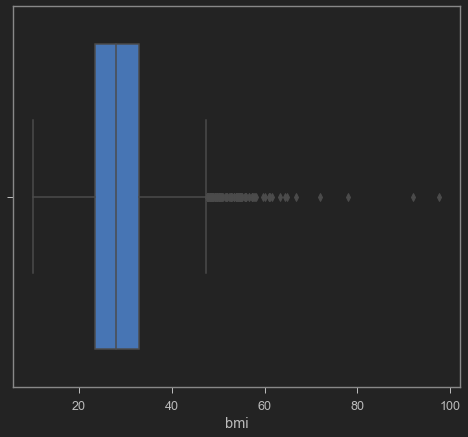

In [14]:
sns.boxplot(data = df, x = df['bmi'])

<AxesSubplot:xlabel='avg_glucose_level'>

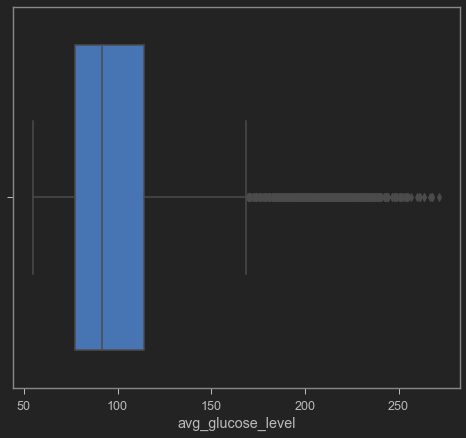

In [15]:
sns.boxplot(data = df, x = df['avg_glucose_level'])

# SCALING

    Robust, reasons : BMI and AVG glucose contains outliers

In [16]:
scale_pipe = Pipeline([
    ('Simple Imputer',SimpleImputer(strategy = 'mean')),
    ('Scaling', RobustScaler())
])
transformer_mean_logreg_scaling = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Scaling', scale_pipe, ['bmi','avg_glucose_level'])
], remainder = 'passthrough')

transformer_mean_logreg = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Simple Imputer', SimpleImputer(strategy = 'mean'), ['bmi'])
], remainder = 'passthrough')

In [17]:
def model_evaluation_cv_mean_overall_logreg():
    model_test = [logreg]
    scaling_method = [transformer_mean_logreg_scaling, transformer_mean_logreg]
    scaling_method_name = ['With Scaling', 'Without Scaling']
    data_comparison = pd.DataFrame({'Model' : ['logreg']})
    skfold = StratifiedKFold(n_splits = 5)
    for i in range(len(scaling_method)):
        temp_list = []
        for j in range(len(model_test)):
            estimator = Pipeline([
            ('preprocess', scaling_method[i]),
            ('balancing', randomover),
            ('model', model_test[j])
        ])
            model_cv = cross_val_score(estimator, x_train, y_train, scoring = 'recall', cv = skfold)
            temp_list.append(round(model_cv.mean(),5))
        data_comparison[scaling_method_name[i]] = temp_list
    return data_comparison

model_evaluation_cv_mean_overall_logreg()            

,Model,With Scaling,Without Scaling
0,logreg,0.78756,0.78168


In [18]:
def overall_func_logreg():
    model_test = [logreg]
    scaling_method = [transformer_mean_logreg_scaling, transformer_mean_logreg]
    scaling_method_name = ['With Scaling', 'Without Scaling']
    data_comparison = pd.DataFrame({'Model' : ['logreg']})
    for i in range(len(scaling_method)):
        temp_list = []
        for j in range(len(model_test)):
            estimator = Pipeline([
                ('transformer', transformer_mean_logreg),
                ('balancing', randomover),
                ('model', model_test[j])])
            estimator.fit(x_train, y_train)
            y_pred = estimator.predict(x_test)
            temp_list.append(recall_score(y_test, y_pred))
        data_comparison[scaling_method_name[i]] = temp_list
    return data_comparison
overall_func_logreg()

,Model,With Scaling,Without Scaling
0,logreg,0.88,0.88


# Last test for model improvement before Hyperparameter Tuning : Polynomial on LogReg

In [19]:
poly_scale = Pipeline([
    ('Simple Imputer',SimpleImputer(strategy = 'mean')),
    ('Poly', PolynomialFeatures(degree = 1, interaction_only = False, include_bias = False)),
    ('Scaling', RobustScaler())
])
transformer_mean_logreg = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('PolynomialRobust', poly_scale, ['bmi','avg_glucose_level'])
], remainder = 'passthrough')

In [20]:
estimator = Pipeline([
    ('preprocess', transformer_mean_logreg),
    ('balancing', randomover),
    ('model', logreg)
])
hyperparam_space =[{
    'preprocess__PolynomialRobust__Poly__degree' : [1, 2,3, 4, 6, 7, 8, 9, 10]}
]

In [21]:
skfold = StratifiedKFold(n_splits = 5)
grid_search = GridSearchCV(estimator, param_grid = hyperparam_space, cv = skfold, scoring = 'recall', n_jobs = -1)

In [22]:
grid_search.fit(x_train, y_train)
print('best score ', grid_search.best_score_)
print('best score ', grid_search.best_params_)

best score  0.7988235294117648
best score  {'preprocess__PolynomialRobust__Poly__degree': 4}


In [23]:
y_pred = grid_search.best_estimator_.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.71      0.82      1458
           1       0.12      0.81      0.22        75

    accuracy                           0.71      1533
   macro avg       0.56      0.76      0.52      1533
weighted avg       0.94      0.71      0.79      1533



# BEST DEGREE OVERALL GOES TO DEGREE 4

    But because the performance is not as good as(no significant improvement) 
    without using polynomial, I won't be using it

# What do we learn so far

    Scaling slighty improve Logreg perfomance by 0.006
    
    Polynomial does slighty improve the model 0.01 during crossvalidating but not as good as
    without one when test predict

# HYPERPARAMETER TUNING

In [47]:
impute = Pipeline([
    ('Simple Imputer',SimpleImputer(strategy = 'mean'))
])
transformer_mean = ColumnTransformer([
    ('One Hot', one_hot, ['gender','ever_married','Residence_type']),
    ('Binary', binary, ['work_type','smoking_status']),
    ('Simple Imputer', impute, ['bmi','avg_glucose_level'])
], remainder = 'passthrough')

In [48]:
logreg = LogisticRegression(solver = 'liblinear', random_state = 2021)
estimator = Pipeline([
    ('preprocess', transformer_mean),
    ('balancing', randomover),
    ('model', logreg)
])

hyperparam_space =[{
    'model__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
    'model__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
]

In [49]:
skfold = StratifiedKFold(n_splits = 5)
grid_search = GridSearchCV(estimator, param_grid = hyperparam_space, cv = skfold, scoring = 'recall', n_jobs = -1)

In [50]:
grid_search.fit(x_train, y_train)
print('best score ', grid_search.best_score_)
print('best score ', grid_search.best_params_)

best score  0.7932773109243698
best score  {'model__C': 0.1, 'model__solver': 'newton-cg'}


In [51]:
y_pred = grid_search.best_estimator_.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.71      0.83      1458
           1       0.13      0.88      0.23        75

    accuracy                           0.72      1533
   macro avg       0.56      0.79      0.53      1533
weighted avg       0.95      0.72      0.80      1533



In [52]:
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predictions 0 Good', 'Predictions 1 Bad'])

,Predictions 0 Good,Predictions 1 Bad
0,1033,425
1,9,66


(<sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x235681d65c8>,
 <sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x23567591e48>)

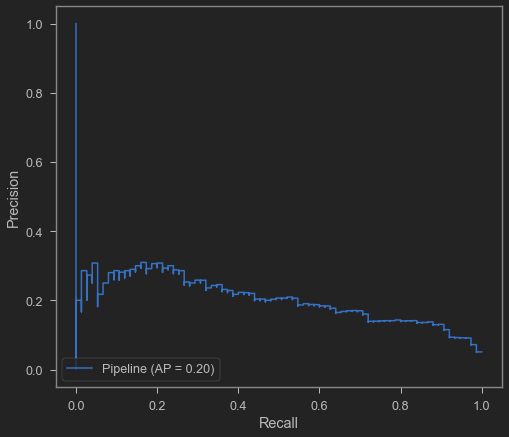

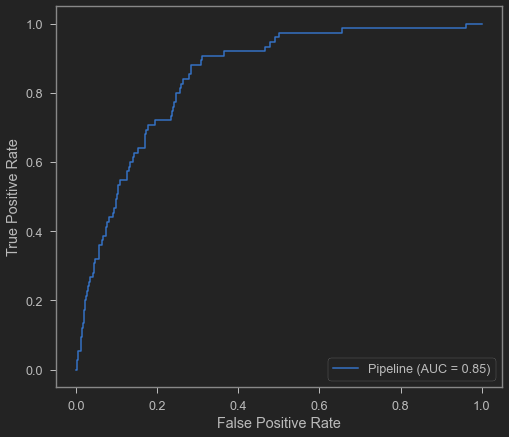

In [53]:
plot_precision_recall_curve(grid_search.best_estimator_, x_test, y_test), plot_roc_curve(grid_search.best_estimator_, x_test, y_test)

# CONCLUSION ON WHAT MODEL AND METHOD TO PICK

    I will be using randomover without any scaling using params 
         model__C : 0.1 
         model__solver : netwon-sg 
    with the score of 0.88 on recall and 0.72 accuracy
    
    Reason for me to decide why I use this as my predictive model eventhough scaling has a higher perfomance during
    crossvalidating was because the difference wasn't that much (0.006), and without scaling, the speed
    perfomance would be much lighter and faster, and so I use RandomOver without scaling instead.

# CHECKING FOR FEATURE IMPORTANCE (Just checking)

In [31]:
grid_search.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('One Hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender', 'ever_married',
                                                   'Residence_type']),
                                                 ('Binary', BinaryEncoder(),
                                                  ['work_type',
                                                   'smoking_status']),
                                                 ('Simple Imputer',
                                                  Pipeline(steps=[('Simple '
                                                                   'Imputer',
                                                                   SimpleImputer())]),
                                                  ['bmi',
                                         

In [32]:
list(grid_search.best_estimator_[0].transformers_[0][1].get_feature_names())

['x0_Male', 'x1_Yes', 'x2_Urban']

In [33]:
grid_search.best_estimator_[0].transformers_[1][1].get_feature_names()

['work_type_0',
 'work_type_1',
 'work_type_2',
 'work_type_3',
 'smoking_status_0',
 'smoking_status_1',
 'smoking_status_2']

In [34]:
grid_search.best_estimator_[0].transformers_[2][2]

['bmi', 'avg_glucose_level']

In [35]:
feature = list(grid_search.best_estimator_[0].transformers_[0][1].get_feature_names()) + grid_search.best_estimator_[0].transformers_[1][1].get_feature_names() + grid_search.best_estimator_[0].transformers_[2][2] + ['age','hypertension','heart_disease']

In [36]:
coef_tab = pd.DataFrame({'index' : feature, 'coef': grid_search.best_estimator_[2].coef_.flatten()}).set_index('index').sort_values('coef', ascending= False)
coef_tab

,coef
index,
hypertension,0.548416
work_type_1,0.495963
smoking_status_0,0.406593
heart_disease,0.217135
smoking_status_1,0.116996
age,0.080335
bmi,0.015721
x2_Urban,0.009898
x1_Yes,0.004013


<AxesSubplot:ylabel='index'>

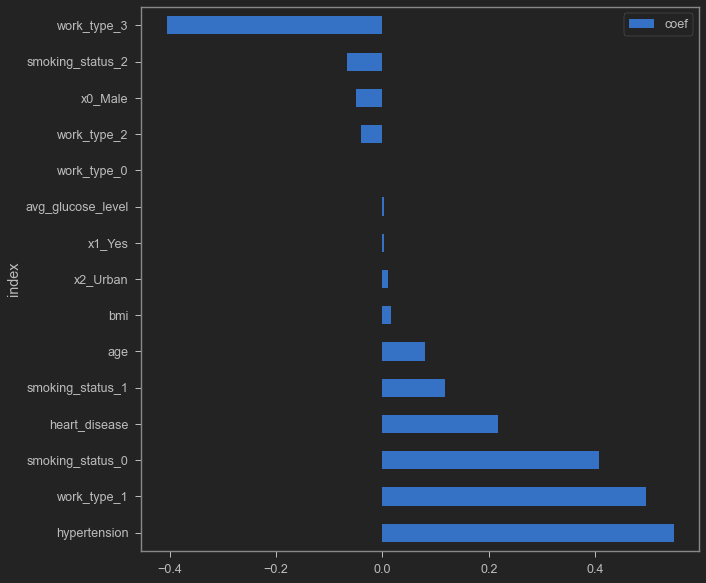

In [37]:
coef_tab.plot(kind= 'barh',figsize=(10,10))

# ###########################################################################

# Saving Model

In [38]:
grid_search.best_estimator_.fit(x, y)
file_name = 'Model Final.sav'
pickle.dump(grid_search.best_estimator_, open(file_name,'wb'))

# Predict with Model

In [39]:
loaded_model = pickle.load(open(file_name,'rb'))

In [40]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [41]:
loaded_model.predict(x_test)

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [42]:
df_predict = pd.DataFrame({
    'gender' : ['Male'],
    'age' : [23],
    'hypertension' : [0],
    'heart_disease' : [0],
    'ever_married' : ['Yes'],
    'work_type' : ['Self-employed'],
    'Residence_type' : ['Urban'],
    'avg_glucose_level' : [98.19],
    'bmi' : [19],
    'smoking_status' : ['never smoked']
})

In [43]:
df_predict

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,23,0,0,Yes,Self-employed,Urban,98.19,19,never smoked


In [44]:
loaded_model.predict(df_predict)

array([0], dtype=int64)

In [45]:
loaded_model.predict_proba(df_predict)

array([[0.97043951, 0.02956049]])